In [2]:
# Core libraries
import os
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

# Models
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import AdaBoostRegressor

In [4]:
data_dir = './data'
print(os.listdir(data_dir))

['sample_submission.csv', 'store.csv', 'test.csv', 'train.csv']


In [6]:
train_df = pd.read_csv(data_dir + './train.csv', low_memory=False)
test_df = pd.read_csv(data_dir + './test.csv')
store_df = pd.read_csv(data_dir + './store.csv')
submission_df = pd.read_csv(data_dir + './sample_submission.csv')

In [8]:
train_df.head(1)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1


In [10]:
test_df.head(1)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0


In [12]:
store_df.head(1)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


In [14]:
# Merging store_df into train_df and test_df
merged_train_df = train_df.merge(store_df, how='left', on='Store')
merged_test_df = test_df.merge(store_df, how='left', on='Store')

In [16]:
merged_train_df.head(1)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


In [18]:
# convert date to datetime and create new column year,month,day & weekofyear
def split_date(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['WeekOfYear'] = df.Date.dt.isocalendar().week

In [20]:
split_date(merged_train_df)
split_date(merged_test_df)

In [22]:
pd.set_option('display.max_columns', None)
merged_train_df.head(1)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31


In [24]:
merged_train_df[merged_train_df.Open == 0].Sales.value_counts()

Sales
0    172817
Name: count, dtype: int64

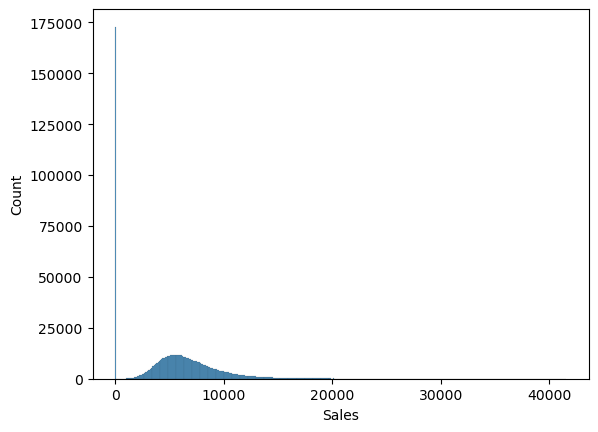

In [26]:
sns.histplot(data = merged_train_df, x = 'Sales')
plt.show()

In [28]:
# Ignoring row where the store is closed
merged_train_df = merged_train_df[merged_train_df.Open == 1].copy()

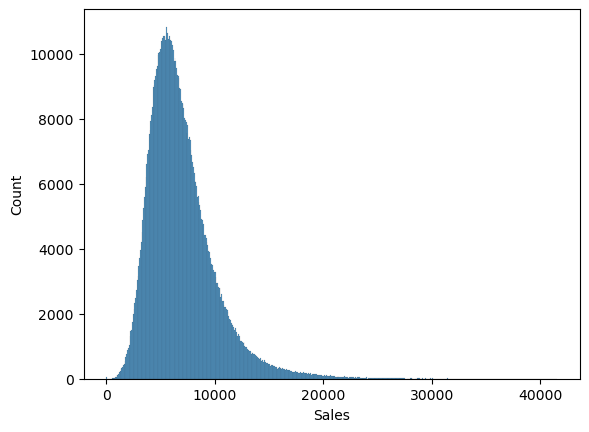

In [30]:
sns.histplot(data = merged_train_df, x = 'Sales')
plt.show()

In [32]:
# Compute CompetitionOpenSince[Month&Year] into total month since open
def comp_months(df):
    df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
    df['CompetitionOpen'] = df['CompetitionOpen'].map(lambda x:0 if x<0 else x).fillna(0)

In [34]:
comp_months(merged_train_df)
comp_months(merged_test_df)

In [36]:
merged_train_df.head(1)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31,82.0


In [38]:
# Create column how long store been running Promo2 & whether new  Promo2 start in current month
def check_promo_month(row):
    month_to_str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
                   7:'July', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (row['PromoIntervel'] or '').split(',')
        if row['Promo2Open'] and month_to_str[row['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0

def promo_cols(df):
    # Months since promo2 wan open
    df['Promo2Open'] = 12 * (df.Year - df.Promo2SinceYear) + (df.WeekOfYear - df.Promo2SinceWeek)*7/30.5
    df['Promo2Open'] = df['Promo2Open'].map(lambda x:0 if x<0 else x).fillna(0) * df['Promo2']
    # Whether new round of promotions started in current month
    df['IsPromo2Month'] = df.apply(check_promo_month, axis=1) * df['Promo2']

In [40]:
promo_cols(merged_train_df)
promo_cols(merged_test_df)

In [42]:
merged_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 844392 entries, 0 to 1017190
Data columns (total 25 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844392 non-null  int64         
 1   DayOfWeek                  844392 non-null  int64         
 2   Date                       844392 non-null  datetime64[ns]
 3   Sales                      844392 non-null  int64         
 4   Customers                  844392 non-null  int64         
 5   Open                       844392 non-null  int64         
 6   Promo                      844392 non-null  int64         
 7   StateHoliday               844392 non-null  object        
 8   SchoolHoliday              844392 non-null  int64         
 9   StoreType                  844392 non-null  object        
 10  Assortment                 844392 non-null  object        
 11  CompetitionDistance        842206 non-null  float64     

In [44]:
#merged_train_df.to_parquet('merged_train_df')
#merged_test_df.to_parquet('merged_test_df')

#merged_train_df = pd.read_parquet('merged_train_df')
#merged_test_df = pd.read_parquet('merged_test_df')

In [46]:
X_cols = ['Store', 'DayOfWeek', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance',
       'Promo2',
       'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'Promo2Open', 'IsPromo2Month']
y_col = 'Sales'

In [48]:
inputs = merged_train_df[X_cols].copy()
target = merged_train_df[y_col].copy()
test_inputs = merged_test_df[X_cols].copy()

In [50]:
inputs.head(1)

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Year,Month,Day,WeekOfYear,CompetitionOpen,Promo2Open,IsPromo2Month
0,1,5,1,0,1,c,a,1270.0,0,2015,7,31,31,82.0,0.0,0


In [52]:
# Categorical and Numerical features columns. (Binary categorical can be treat as numerical)
numeric_cols = ['Store','DayOfWeek','Promo','SchoolHoliday','CompetitionDistance','CompetitionOpen',
               'Promo2','Promo2Open','IsPromo2Month','Day','Month','Year','WeekOfYear']
categorical_cols = ['StateHoliday','StoreType','Assortment']

In [54]:
inputs[numeric_cols].isna().sum()

Store                     0
DayOfWeek                 0
Promo                     0
SchoolHoliday             0
CompetitionDistance    2186
CompetitionOpen           0
Promo2                    0
Promo2Open                0
IsPromo2Month             0
Day                       0
Month                     0
Year                      0
WeekOfYear                0
dtype: int64

In [56]:
# Fill CompetitionDistance with highest value. (Assuming competitor is far away)
max_distance = inputs.CompetitionDistance.max()
#min_distance = inputs.CompetitionDistance.min()
#mean_distance = inputs.CompetitionDistance.mean()

inputs.fillna({'CompetitionDistance': max_distance}, inplace=True)
test_inputs.fillna({'CompetitionDistance': max_distance}, inplace=True)

In [58]:
inputs[numeric_cols].isna().sum()

Store                  0
DayOfWeek              0
Promo                  0
SchoolHoliday          0
CompetitionDistance    0
CompetitionOpen        0
Promo2                 0
Promo2Open             0
IsPromo2Month          0
Day                    0
Month                  0
Year                   0
WeekOfYear             0
dtype: int64

In [60]:
test_inputs[numeric_cols].isna().sum()

Store                  0
DayOfWeek              0
Promo                  0
SchoolHoliday          0
CompetitionDistance    0
CompetitionOpen        0
Promo2                 0
Promo2Open             0
IsPromo2Month          0
Day                    0
Month                  0
Year                   0
WeekOfYear             0
dtype: int64

In [62]:
# Scaling Numeric Values
scaler = MinMaxScaler().fit(inputs[numeric_cols])

In [64]:
inputs.head(1)

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Year,Month,Day,WeekOfYear,CompetitionOpen,Promo2Open,IsPromo2Month
0,1,5,1,0,1,c,a,1270.0,0,2015,7,31,31,82.0,0.0,0


In [66]:
inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

inputs.head(1)

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Year,Month,Day,WeekOfYear,CompetitionOpen,Promo2Open,IsPromo2Month
0,0.0,0.666667,1.0,0,1.0,c,a,0.016482,0.0,1.0,0.545455,1.0,0.588235,0.059163,0.0,0.0


In [68]:
# Encode categorical columns
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

In [70]:
inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

inputs.head(1)

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Year,Month,Day,WeekOfYear,CompetitionOpen,Promo2Open,IsPromo2Month,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,0.0,0.666667,1.0,0,1.0,c,a,0.016482,0.0,1.0,0.545455,1.0,0.588235,0.059163,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [72]:
# Extracting numeric cols for training
X = inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

X.head(1)

,Store,DayOfWeek,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month,Day,Month,Year,WeekOfYear,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,0.0,0.666667,1.0,1.0,0.016482,0.059163,0.0,0.0,0.0,1.0,0.545455,1.0,0.588235,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [74]:
# Split train and validation
X_train, X_val= train_test_split(X, test_size=0.2, random_state=42)

In [76]:
y_train, y_val = train_test_split(target, test_size=0.2, random_state=42)

In [78]:
len(X_train),len(X_val)

(675513, 168879)

In [80]:
len(y_train), len(y_val)

(675513, 168879)

In [82]:
# train with hardcoded model (baseline)
class MeanRegressor():
    def fit(self, inputs, targets):
        self.mean = targets.mean()

    def predict(self, inputs):
        return np.full(inputs.shape[0], self.mean)

mean_model = MeanRegressor()

In [84]:
mean_model.fit(X_train,y_train)
mean_model.mean

6955.755767838665

In [86]:
train_preds = mean_model.predict(X_train)
train_preds

array([6955.75576784, 6955.75576784, 6955.75576784, ..., 6955.75576784,
       6955.75576784, 6955.75576784])

In [88]:
# Evaluation
train_rmse = root_mean_squared_error(y_train, train_preds)
train_rmse

3103.9057239999306

In [90]:
# Train models
model_xgb = XGBRegressor(random_state=42,
                        n_jobs=-1,
                        n_estimators=500,
                        max_depth=10,
                        learning_rate=0.9)
model_cat = CatBoostRegressor(random_state=42,
                             n_estimators=500,
                             max_depth=10,
                             learning_rate=0.9,
                             verbose=0)
model_ada = AdaBoostRegressor(random_state=42,
                             n_estimators=500,
                             learning_rate=0.9)

In [92]:
%%time
model_xgb.fit(X_train,y_train)

CPU times: total: 2min 47s
Wall time: 7.61 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.9, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [94]:
train_xgb_preds = model_xgb.predict(X_train)
val_xgb_preds = model_xgb.predict(X_val)

In [96]:
train_xgb_rmse = root_mean_squared_error(y_train,train_xgb_preds)
val_xgb_rmse = root_mean_squared_error(y_val,val_xgb_preds)

print(f'train_xgb_rmse : {train_xgb_rmse}')
print(f'val_xgb_rmse : {val_xgb_rmse}')

train_xgb_rmse : 286.7403528477294
val_xgb_rmse : 817.4022491524078


In [98]:
%%time
model_cat.fit(X_train,y_train)

CPU times: total: 3min 6s
Wall time: 18.2 s


In [100]:
train_cat_preds = model_cat.predict(X_train)
val_cat_preds = model_cat.predict(X_val)

In [102]:
train_cat_rmse = root_mean_squared_error(y_train,train_cat_preds)
val_cat_rmse = root_mean_squared_error(y_val,val_cat_preds)

print(f'train_cat_rmse : {train_cat_rmse}')
print(f'val_cat_rmse : {val_cat_rmse}')

train_cat_rmse : 636.3134546645406
val_cat_rmse : 735.9433755641029


In [104]:
%%time
model_ada.fit(X_train,y_train)

CPU times: total: 1min 1s
Wall time: 1min 2s


AdaBoostRegressor(learning_rate=0.9, n_estimators=500, random_state=42)

In [106]:
train_ada_preds = model_ada.predict(X_train)
val_ada_preds = model_ada.predict(X_val)

In [108]:
train_ada_rmse = root_mean_squared_error(y_train,train_ada_preds)
val_ada_rmse = root_mean_squared_error(y_val,val_ada_preds)

print(f'train_cat_rmse : {train_ada_rmse}')
print(f'val_cat_rmse : {val_ada_rmse}')

train_cat_rmse : 5478.983728912209
val_cat_rmse : 5478.327900074761


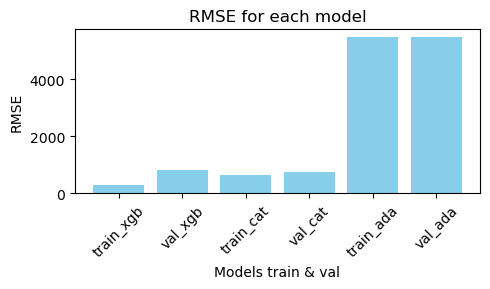

In [110]:
models_rmse = {
    'train_xgb' : train_xgb_rmse,
    'val_xgb' : val_xgb_rmse,
    'train_cat' : train_cat_rmse,
    'val_cat' : val_cat_rmse,
    'train_ada' : train_ada_rmse,
    'val_ada' : val_ada_rmse
}
categories = list(models_rmse.keys())
counts = list(models_rmse.values())

plt.figure(figsize=(5, 3))
plt.bar(categories, counts, color='skyblue')
plt.xlabel('Models train & val')
plt.ylabel('RMSE')
plt.title('RMSE for each model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show();